This notebook is based on `5.0-ayw-neural-network.ipynb`

## Aim of this notebook

In this notebook we will test a fully connected neural network with a variety of architetures to estimate degradation rates in each of the data stages.

## Results 

The best result was obtained by using 6 layers each with 500 neurons and taking a median over a rolling window of width 15

* RMSE for PI signal in the basic dataset is at 0.016%/year
* RMSE for PI signal in soil dataset is at 0.219%/year
* RMSE for PI signal in weather dataset is at 0.264%/year
* RMSE for PI signal in soil_weather dataset is at 0.245%/year
* RMSE for PI signal in soil_weather_uniform dataset is at 0.407%/year

## Analysis

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

import os
import datetime
import pickle

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error

import tensorflow as tf

from src.models.prepare_model import load_PI_data, split_data_training, create_fully_connected_model
from src.models.train_model import train_model
from src.models.predict_model import load_and_predict_model

tf.random.set_seed(42)
np.random.seed(42)

In [2]:
def extract_yr_degrad(avg_power_decay):
    x = np.array([i/365 for i in range(0,len(avg_power_decay))])
    y = np.array(avg_power_decay)
    return np.polyfit(x,y,1)[0]

In [3]:
# Set up the variables
datasets = [
    ('../data/processed/synthetic_basic_pi_daily.zip', 'basic', 50),
    ('../data/processed/synthetic_soil_pi_daily.zip', 'soil', 50),
    ('../data/processed/synthetic_weather_pi_daily.zip', 'weather', 50),
    (('../data/processed/synthetic_soil_weather_pi_daily.zip',
        '../data/processed/synthetic_soil_weather_pi_daily_extra.zip'),
     'soil_weather', (50,100)),
    ('../data/processed/synthetic_soil_weather_pi_daily_uniform.zip', 'soil_weather_uniform', 150)]

name = 'fc_6_layers_fancy'
signal_length = 1825
nr_epochs = 1000
hidden_layers = [501] * 5

X_tests = {}
y_tests = {}
predictions = {}
ys = {}
rmses = {}

def fancy_sigmoid(x):
    return 0.21*tf.keras.backend.sigmoid(x)+0.8

tf.keras.utils.get_custom_objects().update({'fancy_sigmoid': fancy_sigmoid})

In [4]:
# Run
for dataset in datasets:
    print(f"\n Processing {dataset[1]}")
    
    # Read in the data assumes that if dataset[0] is a tuple then dataset[2] is a tuple of the same length
    if isinstance(dataset[0], tuple):
        X = np.empty((0, signal_length), float)
        y = np.empty((0, signal_length), float)
        for i, path in enumerate(dataset[0]):
            X_new, y_new = load_PI_data(path, dataset[2][i], 5)
            X = np.vstack([X, X_new])
            y = np.vstack([y, y_new])
    else:
        X, y = load_PI_data(dataset[0], dataset[2], 5)
    
    # Some preprocessing
    for i, x in enumerate(X):
        temp = pd.Series(x).rolling(15).apply(np.median, raw=True)
        X[i, :] = temp.bfill()
    
    X_train, X_valid, X_test, y_train, y_valid, y_test = split_data_training(X, y)
    X_tests[dataset[1]] = X_test
    y_tests[dataset[1]] = y_test
    
    # Create the model
    model = create_fully_connected_model(signal_length, signal_length, hidden_layers,output_activation='fancy_sigmoid')
    model_name = name + '_' + dataset[1]

    # Get run index
    run_index_path = "./checkpoint/run_index"

    with open(run_index_path, 'r') as f:
        run_index = int(f.readline())
    run_index += 1
    with open(run_index_path, 'w') as f:
        f.write(str(run_index))

    # Train the model
    checpoint_path = train_model(model,
                                 X_train,
                                 y_train,
                                 X_valid,
                                 y_valid,
                                 run_index,
                                 model_name,
                                 "./log/" + dataset[1],
                                 "./checkpoint/" + dataset[1],
                                 nr_epochs,
                                 save_freq=20)
    print(f"Checkpoint for {dataset[1]} dataset is at {checpoint_path}")
    
    # Predict on 
    prediction = load_and_predict_model(checpoint_path, X_test, custom_func={'fancy_sigmoid': fancy_sigmoid})
  
    # Find RMSE
    model_pred = []
    degradation_rates_test = []
    for i in range(0, len(prediction)):
        model_pred.append(extract_yr_degrad(prediction[i, :]))
        degradation_rates_test.append(extract_yr_degrad(y_test[i]))
    mse = mean_squared_error(model_pred, degradation_rates_test)
    
    rmses[dataset[1]] = np.sqrt(mse)
    print(f"RMSE for {dataset[1]} dataset is at {rmses[dataset[1]]}")    
    predictions[dataset[1]] = prediction
    ys[dataset[1]] = y_test


 Processing basic
Epoch 1/1000
2/2 [==============================] - 0s 154ms/step - loss: 0.0081 - val_loss: 0.0132
Epoch 2/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0080 - val_loss: 0.0145
Epoch 3/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0079 - val_loss: 0.0153
Epoch 4/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.0078 - val_loss: 0.0159
Epoch 5/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0077 - val_loss: 0.0163
Epoch 6/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.0075 - val_loss: 0.0166
Epoch 7/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.0073 - val_loss: 0.0170
Epoch 8/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.0070 - val_loss: 0.0170
Epoch 9/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.0067 - val_loss: 0.0171
Epoch 10/1000
2/2 [==============================] - 0s 104ms/step - loss: 0.0064 - val_l

2/2 [==============================] - 0s 28ms/step - loss: 6.8040e-05 - val_loss: 7.3788e-04
Epoch 72/1000
2/2 [==============================] - 0s 28ms/step - loss: 6.1432e-05 - val_loss: 6.7048e-04
Epoch 73/1000
2/2 [==============================] - 0s 27ms/step - loss: 5.4980e-05 - val_loss: 6.2384e-04
Epoch 74/1000
2/2 [==============================] - 0s 26ms/step - loss: 5.1951e-05 - val_loss: 5.8959e-04
Epoch 75/1000
2/2 [==============================] - 0s 29ms/step - loss: 4.8390e-05 - val_loss: 5.6563e-04
Epoch 76/1000
2/2 [==============================] - 0s 27ms/step - loss: 4.3620e-05 - val_loss: 5.4037e-04
Epoch 77/1000
2/2 [==============================] - 0s 29ms/step - loss: 3.8688e-05 - val_loss: 5.2298e-04
Epoch 78/1000
2/2 [==============================] - 0s 29ms/step - loss: 3.8452e-05 - val_loss: 5.0195e-04
Epoch 79/1000
2/2 [==============================] - 0s 26ms/step - loss: 4.0447e-05 - val_loss: 4.8575e-04
Epoch 80/1000
2/2 [=======================

2/2 [==============================] - 1s 540ms/step - loss: 1.2908e-05 - val_loss: 5.6956e-05
Epoch 201/1000
2/2 [==============================] - 0s 30ms/step - loss: 1.1499e-05 - val_loss: 6.0709e-05
Epoch 202/1000
2/2 [==============================] - 0s 28ms/step - loss: 7.9233e-06 - val_loss: 6.9435e-05
Epoch 203/1000
2/2 [==============================] - 0s 28ms/step - loss: 5.5925e-06 - val_loss: 8.2960e-05
Epoch 204/1000
2/2 [==============================] - 0s 27ms/step - loss: 4.2592e-06 - val_loss: 8.7469e-05
Epoch 205/1000
2/2 [==============================] - 0s 29ms/step - loss: 3.4402e-06 - val_loss: 8.3981e-05
Epoch 206/1000
2/2 [==============================] - 0s 28ms/step - loss: 7.1375e-06 - val_loss: 7.3554e-05
Epoch 207/1000
2/2 [==============================] - 0s 27ms/step - loss: 8.4795e-06 - val_loss: 6.3985e-05
Epoch 208/1000
2/2 [==============================] - 0s 30ms/step - loss: 1.2144e-05 - val_loss: 5.9796e-05
Epoch 209/1000
2/2 [=============

2/2 [==============================] - 1s 529ms/step - loss: 7.7896e-06 - val_loss: 1.1879e-05
Epoch 331/1000
2/2 [==============================] - 0s 31ms/step - loss: 1.2311e-05 - val_loss: 1.3332e-05
Epoch 332/1000
2/2 [==============================] - 0s 29ms/step - loss: 1.1341e-05 - val_loss: 1.2968e-05
Epoch 333/1000
2/2 [==============================] - 0s 29ms/step - loss: 8.2489e-06 - val_loss: 8.8295e-06
Epoch 334/1000
2/2 [==============================] - 0s 28ms/step - loss: 1.1617e-05 - val_loss: 7.6222e-06
Epoch 335/1000
2/2 [==============================] - 0s 29ms/step - loss: 3.8846e-06 - val_loss: 8.1514e-06
Epoch 336/1000
2/2 [==============================] - 0s 35ms/step - loss: 4.1771e-06 - val_loss: 1.2310e-05
Epoch 337/1000
2/2 [==============================] - 0s 28ms/step - loss: 9.4809e-06 - val_loss: 1.2436e-05
Epoch 338/1000
2/2 [==============================] - 0s 29ms/step - loss: 9.8464e-06 - val_loss: 8.4645e-06
Epoch 339/1000
2/2 [=============

2/2 [==============================] - 1s 552ms/step - loss: 8.6505e-06 - val_loss: 1.0195e-05
Epoch 461/1000
2/2 [==============================] - 0s 31ms/step - loss: 1.2977e-05 - val_loss: 3.3836e-05
Epoch 462/1000
2/2 [==============================] - 0s 32ms/step - loss: 2.7248e-05 - val_loss: 4.2148e-05
Epoch 463/1000
2/2 [==============================] - 0s 28ms/step - loss: 3.4946e-05 - val_loss: 1.7607e-05
Epoch 464/1000
2/2 [==============================] - 0s 29ms/step - loss: 1.3693e-05 - val_loss: 9.1527e-06
Epoch 465/1000
2/2 [==============================] - 0s 27ms/step - loss: 6.4871e-06 - val_loss: 2.4338e-05
Epoch 466/1000
2/2 [==============================] - 0s 29ms/step - loss: 3.4779e-05 - val_loss: 2.3397e-05
Epoch 467/1000
2/2 [==============================] - 0s 28ms/step - loss: 2.4507e-05 - val_loss: 1.0918e-05
Epoch 468/1000
2/2 [==============================] - 0s 28ms/step - loss: 5.7863e-06 - val_loss: 2.1277e-05
Epoch 469/1000
2/2 [=============

Epoch 590/1000
2/2 [==============================] - 1s 527ms/step - loss: 6.7160e-06 - val_loss: 6.6881e-06
Epoch 591/1000
2/2 [==============================] - 0s 30ms/step - loss: 3.3853e-06 - val_loss: 8.9774e-06
Epoch 592/1000
2/2 [==============================] - 0s 33ms/step - loss: 3.1136e-06 - val_loss: 1.1980e-05
Epoch 593/1000
2/2 [==============================] - 0s 31ms/step - loss: 6.6765e-06 - val_loss: 1.0210e-05
Epoch 594/1000
2/2 [==============================] - 0s 28ms/step - loss: 1.2402e-05 - val_loss: 9.3944e-06
Epoch 595/1000
2/2 [==============================] - 0s 29ms/step - loss: 9.8137e-06 - val_loss: 1.3306e-05
Epoch 596/1000
2/2 [==============================] - 0s 31ms/step - loss: 1.6214e-05 - val_loss: 1.2325e-05
Epoch 597/1000
2/2 [==============================] - 0s 30ms/step - loss: 1.6937e-05 - val_loss: 7.7311e-06
Epoch 598/1000
2/2 [==============================] - 0s 28ms/step - loss: 5.8767e-06 - val_loss: 1.0338e-05
Epoch 599/1000
2/2

2/2 [==============================] - 0s 28ms/step - loss: 4.5040e-06 - val_loss: 1.6772e-05
Epoch 719/1000
2/2 [==============================] - 0s 29ms/step - loss: 1.2598e-05 - val_loss: 1.3890e-05
Epoch 720/1000
2/2 [==============================] - 1s 541ms/step - loss: 8.2959e-06 - val_loss: 9.5350e-06
Epoch 721/1000
2/2 [==============================] - 0s 28ms/step - loss: 4.8940e-06 - val_loss: 7.2021e-06
Epoch 722/1000
2/2 [==============================] - 0s 28ms/step - loss: 4.9506e-06 - val_loss: 6.0923e-06
Epoch 723/1000
2/2 [==============================] - 0s 34ms/step - loss: 5.3275e-06 - val_loss: 5.2929e-06
Epoch 724/1000
2/2 [==============================] - 0s 28ms/step - loss: 7.9762e-06 - val_loss: 6.3696e-06
Epoch 725/1000
2/2 [==============================] - 0s 29ms/step - loss: 3.8797e-06 - val_loss: 9.0891e-06
Epoch 726/1000
2/2 [==============================] - 0s 27ms/step - loss: 6.1932e-06 - val_loss: 8.8731e-06
Epoch 727/1000
2/2 [=============

2/2 [==============================] - 0s 28ms/step - loss: 6.8141e-06 - val_loss: 8.8967e-06
Epoch 847/1000
2/2 [==============================] - 0s 28ms/step - loss: 1.1558e-05 - val_loss: 5.2678e-06
Epoch 848/1000
2/2 [==============================] - 0s 28ms/step - loss: 3.4460e-06 - val_loss: 8.6992e-06
Epoch 849/1000
2/2 [==============================] - 0s 27ms/step - loss: 1.2980e-05 - val_loss: 1.0618e-05
Epoch 850/1000
2/2 [==============================] - 1s 535ms/step - loss: 7.1767e-06 - val_loss: 7.1257e-06
Epoch 851/1000
2/2 [==============================] - 0s 29ms/step - loss: 2.5223e-06 - val_loss: 7.2117e-06
Epoch 852/1000
2/2 [==============================] - 0s 27ms/step - loss: 5.0543e-06 - val_loss: 9.1866e-06
Epoch 853/1000
2/2 [==============================] - 0s 31ms/step - loss: 5.1108e-06 - val_loss: 9.4854e-06
Epoch 854/1000
2/2 [==============================] - 0s 28ms/step - loss: 4.9739e-06 - val_loss: 6.9262e-06
Epoch 855/1000
2/2 [=============

2/2 [==============================] - 1s 510ms/step - loss: 4.0326e-06 - val_loss: 4.7727e-06
Epoch 911/1000
2/2 [==============================] - 0s 30ms/step - loss: 4.0250e-06 - val_loss: 4.5742e-06
Epoch 912/1000
2/2 [==============================] - 0s 30ms/step - loss: 4.2285e-06 - val_loss: 7.7741e-06
Epoch 913/1000
2/2 [==============================] - 0s 29ms/step - loss: 4.6807e-06 - val_loss: 1.9639e-05
Epoch 914/1000
2/2 [==============================] - 0s 29ms/step - loss: 1.1825e-05 - val_loss: 2.0308e-05
Epoch 915/1000
2/2 [==============================] - 0s 28ms/step - loss: 1.3586e-05 - val_loss: 1.2048e-05
Epoch 916/1000
2/2 [==============================] - 0s 27ms/step - loss: 7.8951e-06 - val_loss: 4.2625e-06
Epoch 917/1000
2/2 [==============================] - 0s 27ms/step - loss: 3.5697e-06 - val_loss: 9.8237e-06
Epoch 918/1000
2/2 [==============================] - 0s 28ms/step - loss: 2.4421e-05 - val_loss: 6.7621e-06
Epoch 919/1000
2/2 [=============

2/2 [==============================] - 0s 31ms/step - loss: 0.0037 - val_loss: 0.0084
Epoch 43/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0036 - val_loss: 0.0081
Epoch 44/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.0035 - val_loss: 0.0078
Epoch 45/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0033 - val_loss: 0.0073
Epoch 46/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0032 - val_loss: 0.0070
Epoch 47/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0030 - val_loss: 0.0066
Epoch 48/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.0028 - val_loss: 0.0062
Epoch 49/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.0028 - val_loss: 0.0059
Epoch 50/1000
2/2 [==============================] - 1s 553ms/step - loss: 0.0026 - val_loss: 0.0059
Epoch 51/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.0024 - val_loss: 0.0058
Epoch 52/1000

Epoch 110/1000
2/2 [==============================] - 1s 554ms/step - loss: 1.3231e-04 - val_loss: 7.6020e-04
Epoch 111/1000
2/2 [==============================] - 0s 30ms/step - loss: 2.0803e-04 - val_loss: 7.7868e-04
Epoch 112/1000
2/2 [==============================] - 0s 28ms/step - loss: 1.0755e-04 - val_loss: 8.6091e-04
Epoch 113/1000
2/2 [==============================] - 0s 29ms/step - loss: 1.1929e-04 - val_loss: 9.3322e-04
Epoch 114/1000
2/2 [==============================] - 0s 30ms/step - loss: 1.3919e-04 - val_loss: 0.0010
Epoch 115/1000
2/2 [==============================] - 0s 29ms/step - loss: 1.2603e-04 - val_loss: 0.0011
Epoch 116/1000
2/2 [==============================] - 0s 29ms/step - loss: 1.1852e-04 - val_loss: 0.0011
Epoch 117/1000
2/2 [==============================] - 0s 33ms/step - loss: 1.6518e-04 - val_loss: 0.0012
Epoch 118/1000
2/2 [==============================] - 0s 29ms/step - loss: 2.1955e-04 - val_loss: 0.0012
Epoch 119/1000
2/2 [==================

Epoch 175/1000
2/2 [==============================] - 0s 29ms/step - loss: 1.1972e-04 - val_loss: 9.1411e-04
Epoch 176/1000
2/2 [==============================] - 0s 29ms/step - loss: 1.0213e-04 - val_loss: 9.1140e-04
Epoch 177/1000
2/2 [==============================] - 0s 28ms/step - loss: 1.4145e-04 - val_loss: 9.1075e-04
Epoch 178/1000
2/2 [==============================] - 0s 28ms/step - loss: 1.0766e-04 - val_loss: 9.0575e-04
Epoch 179/1000
2/2 [==============================] - 0s 27ms/step - loss: 1.4171e-04 - val_loss: 8.9507e-04
Epoch 180/1000
2/2 [==============================] - 1s 538ms/step - loss: 1.2400e-04 - val_loss: 8.8635e-04
Epoch 181/1000
2/2 [==============================] - 0s 29ms/step - loss: 1.5989e-04 - val_loss: 8.6801e-04
Epoch 182/1000
2/2 [==============================] - 0s 33ms/step - loss: 1.2091e-04 - val_loss: 8.5255e-04
Epoch 183/1000
2/2 [==============================] - 0s 27ms/step - loss: 1.1471e-04 - val_loss: 8.3577e-04
Epoch 184/1000
2/2

2/2 [==============================] - 1s 539ms/step - loss: 9.6594e-05 - val_loss: 3.0228e-04
Epoch 241/1000
2/2 [==============================] - 0s 27ms/step - loss: 9.9019e-05 - val_loss: 2.9293e-04
Epoch 242/1000
2/2 [==============================] - 0s 26ms/step - loss: 1.0033e-04 - val_loss: 2.9074e-04
Epoch 243/1000
2/2 [==============================] - 0s 28ms/step - loss: 7.4377e-05 - val_loss: 2.8897e-04
Epoch 244/1000
2/2 [==============================] - 0s 28ms/step - loss: 8.8128e-05 - val_loss: 2.8171e-04
Epoch 245/1000
2/2 [==============================] - 0s 27ms/step - loss: 8.5655e-05 - val_loss: 2.7599e-04
Epoch 246/1000
2/2 [==============================] - 0s 28ms/step - loss: 8.8092e-05 - val_loss: 2.6595e-04
Epoch 247/1000
2/2 [==============================] - 0s 32ms/step - loss: 9.3355e-05 - val_loss: 2.5779e-04
Epoch 248/1000
2/2 [==============================] - 0s 27ms/step - loss: 7.6490e-05 - val_loss: 2.5253e-04
Epoch 249/1000
2/2 [=============

2/2 [==============================] - 0s 37ms/step - loss: 1.0949e-04 - val_loss: 4.6392e-04
Epoch 369/1000
2/2 [==============================] - 0s 28ms/step - loss: 1.0139e-04 - val_loss: 4.4054e-04
Epoch 370/1000
2/2 [==============================] - 1s 527ms/step - loss: 1.0228e-04 - val_loss: 4.1676e-04
Epoch 371/1000
2/2 [==============================] - 0s 30ms/step - loss: 1.1280e-04 - val_loss: 3.9750e-04
Epoch 372/1000
2/2 [==============================] - 0s 29ms/step - loss: 9.8999e-05 - val_loss: 4.1990e-04
Epoch 373/1000
2/2 [==============================] - 0s 27ms/step - loss: 8.7884e-05 - val_loss: 4.5403e-04
Epoch 374/1000
2/2 [==============================] - 0s 28ms/step - loss: 9.5245e-05 - val_loss: 4.6471e-04
Epoch 375/1000
2/2 [==============================] - 0s 30ms/step - loss: 1.0185e-04 - val_loss: 4.4885e-04
Epoch 376/1000
2/2 [==============================] - 0s 28ms/step - loss: 8.8365e-05 - val_loss: 4.3254e-04
Epoch 377/1000
2/2 [=============

2/2 [==============================] - 0s 27ms/step - loss: 7.2783e-05 - val_loss: 1.5105e-04
Epoch 497/1000
2/2 [==============================] - 0s 31ms/step - loss: 6.3561e-05 - val_loss: 1.4814e-04
Epoch 498/1000
2/2 [==============================] - 0s 27ms/step - loss: 7.3405e-05 - val_loss: 1.5243e-04
Epoch 499/1000
2/2 [==============================] - 0s 31ms/step - loss: 8.6034e-05 - val_loss: 1.5358e-04
Epoch 500/1000
2/2 [==============================] - 1s 550ms/step - loss: 7.5735e-05 - val_loss: 1.5015e-04
Epoch 501/1000
2/2 [==============================] - 0s 30ms/step - loss: 7.6351e-05 - val_loss: 1.4621e-04
Epoch 502/1000
2/2 [==============================] - 0s 30ms/step - loss: 8.6387e-05 - val_loss: 1.3352e-04
Epoch 503/1000
2/2 [==============================] - 0s 27ms/step - loss: 8.1879e-05 - val_loss: 1.2264e-04
Epoch 504/1000
2/2 [==============================] - 0s 27ms/step - loss: 8.3488e-05 - val_loss: 1.2324e-04
Epoch 505/1000
2/2 [=============

2/2 [==============================] - 1s 551ms/step - loss: 6.5657e-05 - val_loss: 9.0510e-05
Epoch 561/1000
2/2 [==============================] - 0s 29ms/step - loss: 6.8196e-05 - val_loss: 8.9390e-05
Epoch 562/1000
2/2 [==============================] - 0s 27ms/step - loss: 7.0219e-05 - val_loss: 8.9575e-05
Epoch 563/1000
2/2 [==============================] - 0s 28ms/step - loss: 8.2832e-05 - val_loss: 8.6408e-05
Epoch 564/1000
2/2 [==============================] - 0s 31ms/step - loss: 6.4057e-05 - val_loss: 8.0699e-05
Epoch 565/1000
2/2 [==============================] - 0s 27ms/step - loss: 6.6169e-05 - val_loss: 8.2775e-05
Epoch 566/1000
2/2 [==============================] - 0s 29ms/step - loss: 6.2261e-05 - val_loss: 8.6946e-05
Epoch 567/1000
2/2 [==============================] - 0s 26ms/step - loss: 6.9080e-05 - val_loss: 9.5468e-05
Epoch 568/1000
2/2 [==============================] - 0s 27ms/step - loss: 7.4191e-05 - val_loss: 1.0354e-04
Epoch 569/1000
2/2 [=============

Epoch 692/1000
2/2 [==============================] - 0s 29ms/step - loss: 5.6084e-05 - val_loss: 1.0458e-04
Epoch 693/1000
2/2 [==============================] - 0s 26ms/step - loss: 6.7755e-05 - val_loss: 1.0397e-04
Epoch 694/1000
2/2 [==============================] - 0s 26ms/step - loss: 5.8473e-05 - val_loss: 1.0293e-04
Epoch 695/1000
2/2 [==============================] - 0s 31ms/step - loss: 5.8958e-05 - val_loss: 1.0258e-04
Epoch 696/1000
2/2 [==============================] - 0s 32ms/step - loss: 5.8083e-05 - val_loss: 1.0013e-04
Epoch 697/1000
2/2 [==============================] - 0s 29ms/step - loss: 6.3506e-05 - val_loss: 9.8545e-05
Epoch 698/1000
2/2 [==============================] - 0s 33ms/step - loss: 5.9364e-05 - val_loss: 9.7895e-05
Epoch 699/1000
2/2 [==============================] - 0s 28ms/step - loss: 6.9118e-05 - val_loss: 9.9693e-05
Epoch 700/1000
2/2 [==============================] - 1s 540ms/step - loss: 6.6590e-05 - val_loss: 9.8585e-05
Epoch 701/1000
2/2

2/2 [==============================] - 0s 29ms/step - loss: 5.3190e-05 - val_loss: 1.1931e-04
Epoch 758/1000
2/2 [==============================] - 0s 28ms/step - loss: 5.0172e-05 - val_loss: 1.1628e-04
Epoch 759/1000
2/2 [==============================] - 0s 35ms/step - loss: 5.1340e-05 - val_loss: 1.1962e-04
Epoch 760/1000
2/2 [==============================] - 1s 530ms/step - loss: 5.6531e-05 - val_loss: 1.2086e-04
Epoch 761/1000
2/2 [==============================] - 0s 26ms/step - loss: 5.5005e-05 - val_loss: 1.1286e-04
Epoch 762/1000
2/2 [==============================] - 0s 29ms/step - loss: 4.8054e-05 - val_loss: 1.1251e-04
Epoch 763/1000
2/2 [==============================] - 0s 28ms/step - loss: 5.4729e-05 - val_loss: 1.1570e-04
Epoch 764/1000
2/2 [==============================] - 0s 27ms/step - loss: 4.7834e-05 - val_loss: 1.1318e-04
Epoch 765/1000
2/2 [==============================] - 0s 26ms/step - loss: 5.7450e-05 - val_loss: 1.0651e-04
Epoch 766/1000
2/2 [=============

Epoch 821/1000
2/2 [==============================] - 0s 33ms/step - loss: 4.5988e-05 - val_loss: 1.0076e-04
Epoch 822/1000
2/2 [==============================] - 0s 28ms/step - loss: 4.5338e-05 - val_loss: 1.0571e-04
Epoch 823/1000
2/2 [==============================] - 0s 27ms/step - loss: 4.7671e-05 - val_loss: 9.9328e-05
Epoch 824/1000
2/2 [==============================] - 0s 29ms/step - loss: 4.7083e-05 - val_loss: 9.3595e-05
Epoch 825/1000
2/2 [==============================] - 0s 32ms/step - loss: 6.4991e-05 - val_loss: 9.0714e-05
Epoch 826/1000
2/2 [==============================] - 0s 26ms/step - loss: 4.4850e-05 - val_loss: 8.5969e-05
Epoch 827/1000
2/2 [==============================] - 0s 29ms/step - loss: 5.0269e-05 - val_loss: 7.7523e-05
Epoch 828/1000
2/2 [==============================] - 0s 27ms/step - loss: 3.8958e-05 - val_loss: 7.2769e-05
Epoch 829/1000
2/2 [==============================] - 0s 30ms/step - loss: 4.8364e-05 - val_loss: 7.1967e-05
Epoch 830/1000
2/2 

2/2 [==============================] - 0s 28ms/step - loss: 4.0865e-05 - val_loss: 8.4705e-05
Epoch 887/1000
2/2 [==============================] - 0s 29ms/step - loss: 4.6037e-05 - val_loss: 8.5863e-05
Epoch 888/1000
2/2 [==============================] - 0s 28ms/step - loss: 4.6764e-05 - val_loss: 8.4066e-05
Epoch 889/1000
2/2 [==============================] - 0s 30ms/step - loss: 4.5143e-05 - val_loss: 8.0193e-05
Epoch 890/1000
2/2 [==============================] - 1s 533ms/step - loss: 4.0698e-05 - val_loss: 7.5360e-05
Epoch 891/1000
2/2 [==============================] - 0s 28ms/step - loss: 3.9271e-05 - val_loss: 7.6635e-05
Epoch 892/1000
2/2 [==============================] - 0s 28ms/step - loss: 3.8127e-05 - val_loss: 8.5104e-05
Epoch 893/1000
2/2 [==============================] - 0s 26ms/step - loss: 4.2891e-05 - val_loss: 9.3623e-05
Epoch 894/1000
2/2 [==============================] - 0s 28ms/step - loss: 3.7739e-05 - val_loss: 9.9666e-05
Epoch 895/1000
2/2 [=============

2/2 [==============================] - 1s 544ms/step - loss: 3.8952e-05 - val_loss: 7.4960e-05
Epoch 951/1000
2/2 [==============================] - 0s 30ms/step - loss: 4.1221e-05 - val_loss: 6.5603e-05
Epoch 952/1000
2/2 [==============================] - 0s 27ms/step - loss: 3.9573e-05 - val_loss: 5.8556e-05
Epoch 953/1000
2/2 [==============================] - 0s 29ms/step - loss: 3.8008e-05 - val_loss: 5.5256e-05
Epoch 954/1000
2/2 [==============================] - 0s 25ms/step - loss: 4.0188e-05 - val_loss: 5.3662e-05
Epoch 955/1000
2/2 [==============================] - 0s 28ms/step - loss: 3.1866e-05 - val_loss: 5.3688e-05
Epoch 956/1000
2/2 [==============================] - 0s 29ms/step - loss: 3.1902e-05 - val_loss: 5.4343e-05
Epoch 957/1000
2/2 [==============================] - 0s 26ms/step - loss: 4.0761e-05 - val_loss: 5.7856e-05
Epoch 958/1000
2/2 [==============================] - 0s 29ms/step - loss: 3.5963e-05 - val_loss: 6.0275e-05
Epoch 959/1000
2/2 [=============

Epoch 17/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.0058 - val_loss: 0.0145
Epoch 18/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.0057 - val_loss: 0.0147
Epoch 19/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0056 - val_loss: 0.0151
Epoch 20/1000
2/2 [==============================] - 1s 358ms/step - loss: 0.0055 - val_loss: 0.0153
Epoch 21/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.0054 - val_loss: 0.0156
Epoch 22/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.0054 - val_loss: 0.0157
Epoch 23/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.0053 - val_loss: 0.0158
Epoch 24/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.0053 - val_loss: 0.0161
Epoch 25/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0052 - val_loss: 0.0162
Epoch 26/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0051 - val_loss: 0.0162

Epoch 87/1000
2/2 [==============================] - 0s 29ms/step - loss: 9.9582e-05 - val_loss: 0.0012
Epoch 88/1000
2/2 [==============================] - 0s 28ms/step - loss: 9.2900e-05 - val_loss: 0.0012
Epoch 89/1000
2/2 [==============================] - 0s 29ms/step - loss: 9.6074e-05 - val_loss: 0.0012
Epoch 90/1000
2/2 [==============================] - 1s 542ms/step - loss: 9.5522e-05 - val_loss: 0.0012
Epoch 91/1000
2/2 [==============================] - 0s 32ms/step - loss: 8.6528e-05 - val_loss: 0.0012
Epoch 92/1000
2/2 [==============================] - 0s 29ms/step - loss: 9.1223e-05 - val_loss: 0.0012
Epoch 93/1000
2/2 [==============================] - 0s 28ms/step - loss: 8.4330e-05 - val_loss: 0.0011
Epoch 94/1000
2/2 [==============================] - 0s 29ms/step - loss: 7.8300e-05 - val_loss: 0.0011
Epoch 95/1000
2/2 [==============================] - 0s 28ms/step - loss: 7.4209e-05 - val_loss: 0.0011
Epoch 96/1000
2/2 [==============================] - 0s 28ms/st

2/2 [==============================] - 0s 28ms/step - loss: 5.9395e-05 - val_loss: 5.8058e-04
Epoch 217/1000
2/2 [==============================] - 0s 27ms/step - loss: 1.4679e-04 - val_loss: 5.4852e-04
Epoch 218/1000
2/2 [==============================] - 0s 30ms/step - loss: 4.9814e-05 - val_loss: 5.2507e-04
Epoch 219/1000
2/2 [==============================] - 0s 28ms/step - loss: 4.5347e-05 - val_loss: 5.1246e-04
Epoch 220/1000
2/2 [==============================] - 1s 558ms/step - loss: 1.0463e-04 - val_loss: 5.0567e-04
Epoch 221/1000
2/2 [==============================] - 0s 28ms/step - loss: 7.8321e-05 - val_loss: 4.5601e-04
Epoch 222/1000
2/2 [==============================] - 0s 27ms/step - loss: 4.3061e-05 - val_loss: 3.8663e-04
Epoch 223/1000
2/2 [==============================] - 0s 26ms/step - loss: 4.8937e-05 - val_loss: 3.4989e-04
Epoch 224/1000
2/2 [==============================] - 0s 29ms/step - loss: 6.8664e-05 - val_loss: 3.4396e-04
Epoch 225/1000
2/2 [=============

2/2 [==============================] - 1s 524ms/step - loss: 7.4461e-05 - val_loss: 9.3762e-04
Epoch 281/1000
2/2 [==============================] - 0s 27ms/step - loss: 8.5673e-05 - val_loss: 9.4162e-04
Epoch 282/1000
2/2 [==============================] - 0s 29ms/step - loss: 7.3313e-05 - val_loss: 9.2634e-04
Epoch 283/1000
2/2 [==============================] - 0s 28ms/step - loss: 8.9649e-05 - val_loss: 8.9715e-04
Epoch 284/1000
2/2 [==============================] - 0s 28ms/step - loss: 5.1122e-05 - val_loss: 8.4515e-04
Epoch 285/1000
2/2 [==============================] - 0s 27ms/step - loss: 5.6566e-05 - val_loss: 7.9066e-04
Epoch 286/1000
2/2 [==============================] - 0s 32ms/step - loss: 7.0370e-05 - val_loss: 7.6474e-04
Epoch 287/1000
2/2 [==============================] - 0s 29ms/step - loss: 7.6617e-05 - val_loss: 7.4784e-04
Epoch 288/1000
2/2 [==============================] - 0s 30ms/step - loss: 5.3849e-05 - val_loss: 7.2169e-04
Epoch 289/1000
2/2 [=============

Epoch 411/1000
2/2 [==============================] - 0s 29ms/step - loss: 6.6565e-05 - val_loss: 1.1503e-04
Epoch 412/1000
2/2 [==============================] - 0s 27ms/step - loss: 6.2892e-05 - val_loss: 1.2418e-04
Epoch 413/1000
2/2 [==============================] - 0s 29ms/step - loss: 6.2450e-05 - val_loss: 1.2828e-04
Epoch 414/1000
2/2 [==============================] - 0s 29ms/step - loss: 6.4645e-05 - val_loss: 1.2349e-04
Epoch 415/1000
2/2 [==============================] - 0s 29ms/step - loss: 6.3707e-05 - val_loss: 1.1970e-04
Epoch 416/1000
2/2 [==============================] - 0s 28ms/step - loss: 7.2963e-05 - val_loss: 1.2680e-04
Epoch 417/1000
2/2 [==============================] - 0s 32ms/step - loss: 5.3553e-05 - val_loss: 1.2034e-04
Epoch 418/1000
2/2 [==============================] - 0s 25ms/step - loss: 6.2101e-05 - val_loss: 1.0873e-04
Epoch 419/1000
2/2 [==============================] - 0s 29ms/step - loss: 5.6124e-05 - val_loss: 1.0340e-04
Epoch 420/1000
2/2 

2/2 [==============================] - 0s 28ms/step - loss: 5.5257e-05 - val_loss: 1.0646e-04
Epoch 477/1000
2/2 [==============================] - 0s 28ms/step - loss: 5.1773e-05 - val_loss: 1.0592e-04
Epoch 478/1000
2/2 [==============================] - 0s 27ms/step - loss: 5.8161e-05 - val_loss: 9.6321e-05
Epoch 479/1000
2/2 [==============================] - 0s 28ms/step - loss: 5.5622e-05 - val_loss: 8.3960e-05
Epoch 480/1000
2/2 [==============================] - 1s 567ms/step - loss: 5.1184e-05 - val_loss: 7.9386e-05
Epoch 481/1000
2/2 [==============================] - 0s 28ms/step - loss: 5.7063e-05 - val_loss: 8.5594e-05
Epoch 482/1000
2/2 [==============================] - 0s 28ms/step - loss: 5.4359e-05 - val_loss: 9.8672e-05
Epoch 483/1000
2/2 [==============================] - 0s 32ms/step - loss: 6.6531e-05 - val_loss: 1.0805e-04
Epoch 484/1000
2/2 [==============================] - 0s 26ms/step - loss: 8.4993e-05 - val_loss: 1.2012e-04
Epoch 485/1000
2/2 [=============

2/2 [==============================] - 1s 565ms/step - loss: 3.9620e-05 - val_loss: 2.5399e-04
Epoch 541/1000
2/2 [==============================] - 0s 29ms/step - loss: 4.0400e-05 - val_loss: 2.3499e-04
Epoch 542/1000
2/2 [==============================] - 0s 28ms/step - loss: 4.2906e-05 - val_loss: 2.2141e-04
Epoch 543/1000
2/2 [==============================] - 0s 28ms/step - loss: 3.5004e-05 - val_loss: 1.9708e-04
Epoch 544/1000
2/2 [==============================] - 0s 27ms/step - loss: 5.0081e-05 - val_loss: 1.7480e-04
Epoch 545/1000
2/2 [==============================] - 0s 29ms/step - loss: 3.8672e-05 - val_loss: 1.7285e-04
Epoch 546/1000
2/2 [==============================] - 0s 27ms/step - loss: 4.8047e-05 - val_loss: 1.7916e-04
Epoch 547/1000
2/2 [==============================] - 0s 26ms/step - loss: 4.2533e-05 - val_loss: 1.8816e-04
Epoch 548/1000
2/2 [==============================] - 0s 26ms/step - loss: 6.3888e-05 - val_loss: 1.9586e-04
Epoch 549/1000
2/2 [=============

Epoch 605/1000
2/2 [==============================] - 0s 28ms/step - loss: 4.1532e-05 - val_loss: 5.4556e-04
Epoch 606/1000
2/2 [==============================] - 0s 27ms/step - loss: 4.8879e-05 - val_loss: 5.0875e-04
Epoch 607/1000
2/2 [==============================] - 0s 30ms/step - loss: 4.7054e-05 - val_loss: 5.8265e-04
Epoch 608/1000
2/2 [==============================] - 0s 29ms/step - loss: 4.7116e-05 - val_loss: 6.2790e-04
Epoch 609/1000
2/2 [==============================] - 0s 27ms/step - loss: 5.0174e-05 - val_loss: 6.0863e-04
Epoch 610/1000
2/2 [==============================] - 1s 540ms/step - loss: 4.6692e-05 - val_loss: 6.1443e-04
Epoch 611/1000
2/2 [==============================] - 0s 29ms/step - loss: 5.1887e-05 - val_loss: 6.9557e-04
Epoch 612/1000
2/2 [==============================] - 0s 29ms/step - loss: 4.9519e-05 - val_loss: 8.2137e-04
Epoch 613/1000
2/2 [==============================] - 0s 32ms/step - loss: 4.2887e-05 - val_loss: 9.2761e-04
Epoch 614/1000
2/2

2/2 [==============================] - 0s 26ms/step - loss: 4.0648e-05 - val_loss: 1.6718e-04
Epoch 734/1000
2/2 [==============================] - 0s 30ms/step - loss: 4.5456e-05 - val_loss: 1.6865e-04
Epoch 735/1000
2/2 [==============================] - 0s 28ms/step - loss: 3.7691e-05 - val_loss: 1.7178e-04
Epoch 736/1000
2/2 [==============================] - 0s 27ms/step - loss: 3.5009e-05 - val_loss: 1.6576e-04
Epoch 737/1000
2/2 [==============================] - 0s 29ms/step - loss: 5.5826e-05 - val_loss: 1.5353e-04
Epoch 738/1000
2/2 [==============================] - 0s 26ms/step - loss: 3.7010e-05 - val_loss: 1.5675e-04
Epoch 739/1000
2/2 [==============================] - 0s 27ms/step - loss: 3.6291e-05 - val_loss: 1.5639e-04
Epoch 740/1000
2/2 [==============================] - 1s 555ms/step - loss: 4.4115e-05 - val_loss: 1.5046e-04
Epoch 741/1000
2/2 [==============================] - 0s 28ms/step - loss: 3.9551e-05 - val_loss: 1.4687e-04
Epoch 742/1000
2/2 [=============

4/4 [==============================] - 0s 26ms/step - loss: 8.8381e-06 - val_loss: 7.9052e-05
Epoch 134/1000
4/4 [==============================] - 0s 27ms/step - loss: 7.4276e-06 - val_loss: 8.6485e-05
Epoch 135/1000
4/4 [==============================] - 1s 332ms/step - loss: 9.9479e-06 - val_loss: 8.2620e-05
Epoch 136/1000
4/4 [==============================] - 0s 29ms/step - loss: 6.6220e-06 - val_loss: 7.6698e-05
Epoch 137/1000
4/4 [==============================] - 0s 26ms/step - loss: 1.4846e-05 - val_loss: 1.3558e-04
Epoch 138/1000
4/4 [==============================] - 0s 29ms/step - loss: 4.7690e-06 - val_loss: 1.4984e-04
Epoch 139/1000
4/4 [==============================] - 0s 27ms/step - loss: 7.3698e-06 - val_loss: 1.0349e-04
Epoch 140/1000
4/4 [==============================] - 1s 326ms/step - loss: 5.7839e-06 - val_loss: 1.0448e-04
Epoch 141/1000
4/4 [==============================] - 0s 29ms/step - loss: 8.8194e-06 - val_loss: 6.7619e-05
Epoch 142/1000
4/4 [============

4/4 [==============================] - 0s 29ms/step - loss: 7.0899e-06 - val_loss: 1.8617e-04
Epoch 284/1000
4/4 [==============================] - 0s 28ms/step - loss: 8.9041e-06 - val_loss: 1.9001e-04
Epoch 285/1000
4/4 [==============================] - 1s 330ms/step - loss: 1.1441e-05 - val_loss: 1.3000e-04
Epoch 286/1000
4/4 [==============================] - 0s 29ms/step - loss: 6.6468e-06 - val_loss: 1.5172e-04
Epoch 287/1000
4/4 [==============================] - 0s 28ms/step - loss: 6.3864e-06 - val_loss: 6.6078e-05
Epoch 288/1000
4/4 [==============================] - 0s 27ms/step - loss: 7.1127e-06 - val_loss: 6.2737e-05
Epoch 289/1000
4/4 [==============================] - 0s 29ms/step - loss: 6.9712e-06 - val_loss: 1.0177e-04
Epoch 290/1000
4/4 [==============================] - 1s 331ms/step - loss: 9.0664e-06 - val_loss: 1.1216e-04
Epoch 291/1000
4/4 [==============================] - 0s 29ms/step - loss: 5.2997e-06 - val_loss: 1.5250e-04
Epoch 292/1000
4/4 [============

4/4 [==============================] - 0s 28ms/step - loss: 2.2202e-06 - val_loss: 3.4778e-04
Epoch 434/1000
4/4 [==============================] - 0s 27ms/step - loss: 5.2993e-06 - val_loss: 2.9664e-04
Epoch 435/1000
4/4 [==============================] - 1s 325ms/step - loss: 2.5799e-06 - val_loss: 3.0474e-04
Epoch 436/1000
4/4 [==============================] - 0s 30ms/step - loss: 5.5103e-06 - val_loss: 2.8412e-04
Epoch 437/1000
4/4 [==============================] - 0s 29ms/step - loss: 2.8377e-06 - val_loss: 1.3425e-04
Epoch 438/1000
4/4 [==============================] - 0s 28ms/step - loss: 3.3892e-06 - val_loss: 6.5510e-05
Epoch 439/1000
4/4 [==============================] - 0s 28ms/step - loss: 4.7678e-06 - val_loss: 6.4870e-05
Epoch 440/1000
4/4 [==============================] - 1s 324ms/step - loss: 3.0213e-06 - val_loss: 6.5302e-05
Epoch 441/1000
4/4 [==============================] - 0s 26ms/step - loss: 1.9984e-06 - val_loss: 6.8148e-05
Epoch 442/1000
4/4 [============

4/4 [==============================] - 0s 30ms/step - loss: 6.9895e-06 - val_loss: 1.2120e-04
Epoch 584/1000
4/4 [==============================] - 0s 27ms/step - loss: 3.4765e-06 - val_loss: 1.3768e-04
Epoch 585/1000
4/4 [==============================] - 1s 323ms/step - loss: 4.9495e-06 - val_loss: 1.2945e-04
Epoch 586/1000
4/4 [==============================] - 0s 28ms/step - loss: 2.8107e-06 - val_loss: 2.0985e-04
Epoch 587/1000
4/4 [==============================] - 0s 27ms/step - loss: 6.3685e-06 - val_loss: 2.6178e-04
Epoch 588/1000
4/4 [==============================] - 0s 28ms/step - loss: 5.9157e-06 - val_loss: 1.9886e-04
Epoch 589/1000
4/4 [==============================] - 0s 29ms/step - loss: 2.9139e-06 - val_loss: 1.8536e-04
Epoch 590/1000
4/4 [==============================] - 1s 323ms/step - loss: 8.3478e-06 - val_loss: 1.1263e-04
Epoch 591/1000
4/4 [==============================] - 0s 29ms/step - loss: 6.7830e-06 - val_loss: 8.1466e-05
Epoch 592/1000
4/4 [============

4/4 [==============================] - 0s 30ms/step - loss: 2.2020e-06 - val_loss: 2.1185e-04
Epoch 734/1000
4/4 [==============================] - 0s 28ms/step - loss: 3.7386e-06 - val_loss: 1.6207e-04
Epoch 735/1000
4/4 [==============================] - 1s 332ms/step - loss: 2.5737e-06 - val_loss: 1.5610e-04
Epoch 736/1000
4/4 [==============================] - 0s 27ms/step - loss: 7.5807e-06 - val_loss: 1.3110e-04
Epoch 737/1000
4/4 [==============================] - 0s 29ms/step - loss: 5.6043e-06 - val_loss: 1.3710e-04
Epoch 738/1000
4/4 [==============================] - 0s 29ms/step - loss: 3.3543e-06 - val_loss: 1.9806e-04
Epoch 739/1000
4/4 [==============================] - 0s 28ms/step - loss: 5.7715e-06 - val_loss: 2.2757e-04
Epoch 740/1000
4/4 [==============================] - 1s 340ms/step - loss: 7.5199e-06 - val_loss: 1.6813e-04
Epoch 741/1000
4/4 [==============================] - 0s 29ms/step - loss: 3.4259e-06 - val_loss: 1.4855e-04
Epoch 742/1000
4/4 [============

Epoch 808/1000
4/4 [==============================] - 0s 28ms/step - loss: 2.7189e-06 - val_loss: 6.9175e-05
Epoch 809/1000
4/4 [==============================] - 0s 28ms/step - loss: 4.0392e-06 - val_loss: 6.6653e-05
Epoch 810/1000
4/4 [==============================] - 1s 328ms/step - loss: 2.6313e-06 - val_loss: 8.1189e-05
Epoch 811/1000
4/4 [==============================] - 0s 27ms/step - loss: 6.6731e-06 - val_loss: 1.2125e-04
Epoch 812/1000
4/4 [==============================] - 0s 29ms/step - loss: 2.7600e-06 - val_loss: 2.2751e-04
Epoch 813/1000
4/4 [==============================] - 0s 29ms/step - loss: 3.2914e-06 - val_loss: 2.1147e-04
Epoch 814/1000
4/4 [==============================] - 0s 28ms/step - loss: 5.3080e-06 - val_loss: 1.7567e-04
Epoch 815/1000
4/4 [==============================] - 1s 321ms/step - loss: 3.7620e-06 - val_loss: 9.1374e-05
Epoch 816/1000
4/4 [==============================] - 0s 28ms/step - loss: 4.2065e-06 - val_loss: 5.7848e-05
Epoch 817/1000
4/

4/4 [==============================] - 0s 28ms/step - loss: 2.7861e-06 - val_loss: 1.3445e-04
Epoch 884/1000
4/4 [==============================] - 0s 28ms/step - loss: 4.8884e-06 - val_loss: 1.0979e-04
Epoch 885/1000
4/4 [==============================] - 1s 329ms/step - loss: 6.3449e-06 - val_loss: 1.1991e-04
Epoch 886/1000
4/4 [==============================] - 0s 26ms/step - loss: 1.1089e-05 - val_loss: 2.2959e-04
Epoch 887/1000
4/4 [==============================] - 0s 29ms/step - loss: 2.7629e-06 - val_loss: 2.3007e-04
Epoch 888/1000
4/4 [==============================] - 0s 28ms/step - loss: 4.4005e-06 - val_loss: 1.7756e-04
Epoch 889/1000
4/4 [==============================] - 0s 27ms/step - loss: 2.9934e-06 - val_loss: 1.7392e-04
Epoch 890/1000
4/4 [==============================] - 1s 328ms/step - loss: 1.3732e-06 - val_loss: 1.8292e-04
Epoch 891/1000
4/4 [==============================] - 0s 28ms/step - loss: 4.7189e-06 - val_loss: 1.2615e-04
Epoch 892/1000
4/4 [============

4/4 [==============================] - 0s 27ms/step - loss: 1.0420e-04 - val_loss: 0.0011
Epoch 34/1000
4/4 [==============================] - 0s 28ms/step - loss: 8.9609e-05 - val_loss: 0.0011
Epoch 35/1000
4/4 [==============================] - 1s 325ms/step - loss: 5.1231e-05 - val_loss: 0.0010
Epoch 36/1000
4/4 [==============================] - 0s 29ms/step - loss: 5.1454e-05 - val_loss: 0.0010
Epoch 37/1000
4/4 [==============================] - 0s 29ms/step - loss: 3.7827e-05 - val_loss: 0.0010
Epoch 38/1000
4/4 [==============================] - 0s 28ms/step - loss: 3.6133e-05 - val_loss: 0.0011
Epoch 39/1000
4/4 [==============================] - 0s 30ms/step - loss: 3.8261e-05 - val_loss: 0.0011
Epoch 40/1000
4/4 [==============================] - 1s 320ms/step - loss: 3.0556e-05 - val_loss: 0.0010
Epoch 41/1000
4/4 [==============================] - 0s 29ms/step - loss: 2.8627e-05 - val_loss: 0.0010
Epoch 42/1000
4/4 [==============================] - 0s 27ms/step - loss: 5.

4/4 [==============================] - 0s 30ms/step - loss: 1.6789e-05 - val_loss: 4.1229e-04
Epoch 185/1000
4/4 [==============================] - 1s 329ms/step - loss: 9.7714e-06 - val_loss: 4.1581e-04
Epoch 186/1000
4/4 [==============================] - 0s 28ms/step - loss: 1.5166e-05 - val_loss: 3.7608e-04
Epoch 187/1000
4/4 [==============================] - 0s 28ms/step - loss: 1.1565e-05 - val_loss: 3.3962e-04
Epoch 188/1000
4/4 [==============================] - 0s 27ms/step - loss: 1.0733e-05 - val_loss: 3.4398e-04
Epoch 189/1000
4/4 [==============================] - 0s 27ms/step - loss: 2.4840e-05 - val_loss: 1.7732e-04
Epoch 190/1000
4/4 [==============================] - 1s 326ms/step - loss: 1.2484e-05 - val_loss: 2.0064e-04
Epoch 191/1000
4/4 [==============================] - 0s 28ms/step - loss: 9.3516e-06 - val_loss: 1.4037e-04
Epoch 192/1000
4/4 [==============================] - 0s 29ms/step - loss: 8.0963e-06 - val_loss: 1.8488e-04
Epoch 193/1000
4/4 [============

Epoch 260/1000
4/4 [==============================] - 1s 322ms/step - loss: 1.3149e-05 - val_loss: 5.8470e-04
Epoch 261/1000
4/4 [==============================] - 0s 33ms/step - loss: 9.4659e-06 - val_loss: 5.0144e-04
Epoch 262/1000
4/4 [==============================] - 0s 29ms/step - loss: 8.1815e-06 - val_loss: 3.3684e-04
Epoch 263/1000
4/4 [==============================] - 0s 26ms/step - loss: 1.1022e-05 - val_loss: 2.9415e-04
Epoch 264/1000
4/4 [==============================] - 0s 28ms/step - loss: 1.5593e-05 - val_loss: 2.7201e-04
Epoch 265/1000
4/4 [==============================] - 1s 325ms/step - loss: 1.9681e-05 - val_loss: 2.9527e-04
Epoch 266/1000
4/4 [==============================] - 0s 26ms/step - loss: 1.5085e-05 - val_loss: 4.3848e-04
Epoch 267/1000
4/4 [==============================] - 0s 30ms/step - loss: 2.7923e-05 - val_loss: 5.1347e-04
Epoch 268/1000
4/4 [==============================] - 0s 28ms/step - loss: 6.0020e-06 - val_loss: 6.1315e-04
Epoch 269/1000
4/

4/4 [==============================] - 1s 330ms/step - loss: 2.6347e-05 - val_loss: 0.0016
Epoch 411/1000
4/4 [==============================] - 0s 28ms/step - loss: 2.2639e-05 - val_loss: 0.0016
Epoch 412/1000
4/4 [==============================] - 0s 27ms/step - loss: 1.2115e-05 - val_loss: 0.0015
Epoch 413/1000
4/4 [==============================] - 0s 28ms/step - loss: 3.0861e-05 - val_loss: 0.0015
Epoch 414/1000
4/4 [==============================] - 0s 33ms/step - loss: 2.4904e-05 - val_loss: 0.0015
Epoch 415/1000
4/4 [==============================] - 1s 322ms/step - loss: 4.6521e-05 - val_loss: 0.0015
Epoch 416/1000
4/4 [==============================] - 0s 28ms/step - loss: 3.6067e-05 - val_loss: 0.0015
Epoch 417/1000
4/4 [==============================] - 0s 30ms/step - loss: 1.7279e-05 - val_loss: 0.0015
Epoch 418/1000
4/4 [==============================] - 0s 28ms/step - loss: 1.8317e-05 - val_loss: 0.0015
Epoch 419/1000
4/4 [==============================] - 0s 30ms/step -

Epoch 486/1000
4/4 [==============================] - 0s 28ms/step - loss: 1.4205e-05 - val_loss: 3.8519e-04
Epoch 487/1000
4/4 [==============================] - 0s 28ms/step - loss: 4.2023e-05 - val_loss: 5.3548e-04
Epoch 488/1000
4/4 [==============================] - 0s 28ms/step - loss: 1.6714e-05 - val_loss: 5.4756e-04
Epoch 489/1000
4/4 [==============================] - 0s 28ms/step - loss: 2.2109e-05 - val_loss: 5.8423e-04
Epoch 490/1000
4/4 [==============================] - 1s 324ms/step - loss: 1.9149e-05 - val_loss: 4.0984e-04
Epoch 491/1000
4/4 [==============================] - 0s 29ms/step - loss: 1.6206e-05 - val_loss: 3.1596e-04
Epoch 492/1000
4/4 [==============================] - 0s 28ms/step - loss: 9.1025e-06 - val_loss: 2.3663e-04
Epoch 493/1000
4/4 [==============================] - 0s 29ms/step - loss: 8.0639e-06 - val_loss: 1.8515e-04
Epoch 494/1000
4/4 [==============================] - 0s 27ms/step - loss: 9.3365e-06 - val_loss: 1.5368e-04
Epoch 495/1000
4/4

4/4 [==============================] - 0s 27ms/step - loss: 3.1004e-05 - val_loss: 1.0265e-04
Epoch 562/1000
4/4 [==============================] - 0s 28ms/step - loss: 6.1164e-06 - val_loss: 1.3073e-04
Epoch 563/1000
4/4 [==============================] - 0s 29ms/step - loss: 1.8813e-05 - val_loss: 1.3133e-04
Epoch 564/1000
4/4 [==============================] - 0s 29ms/step - loss: 1.3472e-05 - val_loss: 1.3408e-04
Epoch 565/1000
4/4 [==============================] - 1s 322ms/step - loss: 2.9527e-05 - val_loss: 1.0666e-04
Epoch 566/1000
4/4 [==============================] - 0s 29ms/step - loss: 9.5871e-06 - val_loss: 1.0992e-04
Epoch 567/1000
4/4 [==============================] - 0s 35ms/step - loss: 8.7426e-06 - val_loss: 1.2789e-04
Epoch 568/1000
4/4 [==============================] - 0s 29ms/step - loss: 2.1871e-05 - val_loss: 1.9086e-04
Epoch 569/1000
4/4 [==============================] - 0s 28ms/step - loss: 1.9710e-05 - val_loss: 2.2019e-04
Epoch 570/1000
4/4 [=============

4/4 [==============================] - 0s 27ms/step - loss: 9.1543e-06 - val_loss: 3.2961e-04
Epoch 712/1000
4/4 [==============================] - 0s 27ms/step - loss: 1.1134e-05 - val_loss: 3.7417e-04
Epoch 713/1000
4/4 [==============================] - 0s 27ms/step - loss: 3.4736e-05 - val_loss: 1.9619e-04
Epoch 714/1000
4/4 [==============================] - 0s 30ms/step - loss: 1.1604e-05 - val_loss: 2.6892e-04
Epoch 715/1000
4/4 [==============================] - 1s 330ms/step - loss: 1.9519e-05 - val_loss: 5.5721e-04
Epoch 716/1000
4/4 [==============================] - 0s 28ms/step - loss: 1.3897e-05 - val_loss: 3.4479e-04
Epoch 717/1000
4/4 [==============================] - 0s 31ms/step - loss: 1.5840e-05 - val_loss: 1.4458e-04
Epoch 718/1000
4/4 [==============================] - 0s 26ms/step - loss: 1.4592e-05 - val_loss: 1.6766e-04
Epoch 719/1000
4/4 [==============================] - 0s 29ms/step - loss: 1.8579e-05 - val_loss: 1.5038e-04
Epoch 720/1000
4/4 [=============

RMSE for soil_weather_uniform dataset is at 0.0040714654192119705


In [5]:
pickle.dump((predictions, ys, rmses, X_tests, y_tests), open(name + "_outcomes.p", "wb" ))

## Visualise the results 

In [6]:
# What's the meaning of these RMSEs?
for dataset in datasets:
    print(f"RMSE for normalised {dataset[1]} dataset is at {rmses[dataset[1]]*100:0.3f}%/year") 

RMSE for normalised basic dataset is at 0.016%/year
RMSE for normalised soil dataset is at 0.219%/year
RMSE for normalised weather dataset is at 0.264%/year
RMSE for normalised soil_weather dataset is at 0.245%/year
RMSE for normalised soil_weather_uniform dataset is at 0.407%/year


Displaying basic dataset


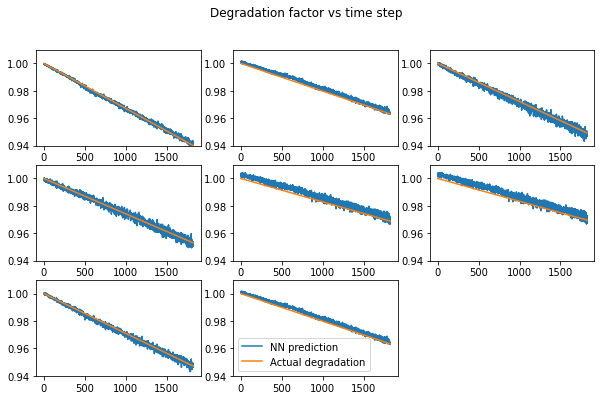

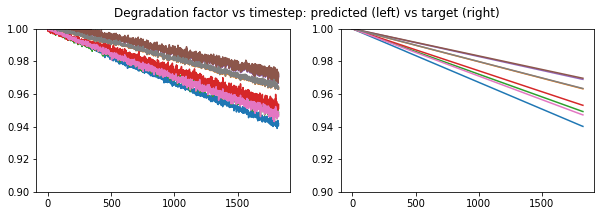

Displaying soil dataset


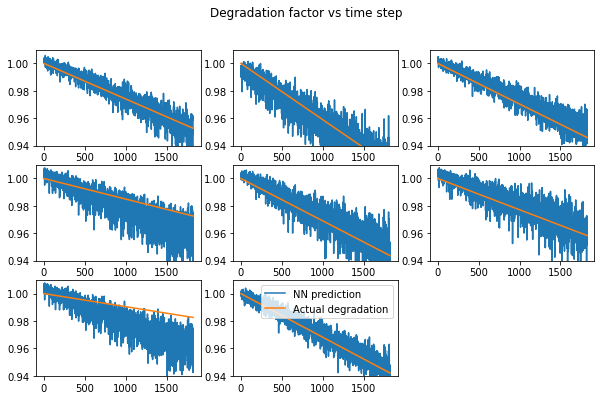

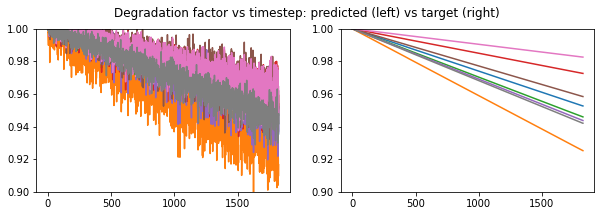

Displaying weather dataset


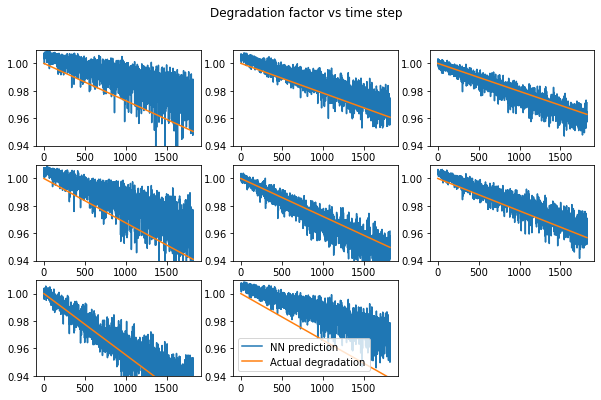

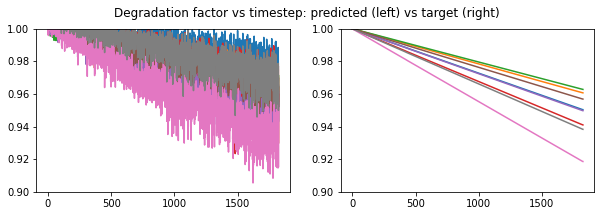

Displaying soil_weather dataset


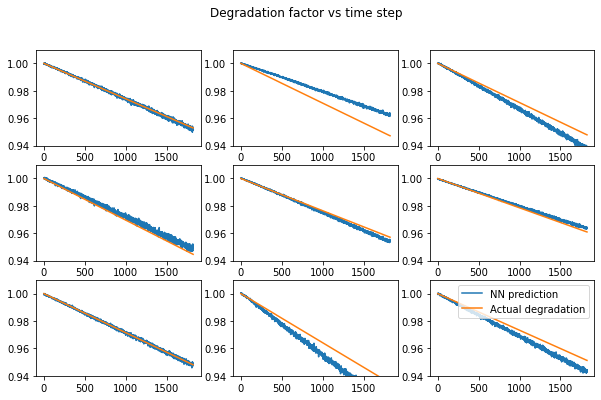

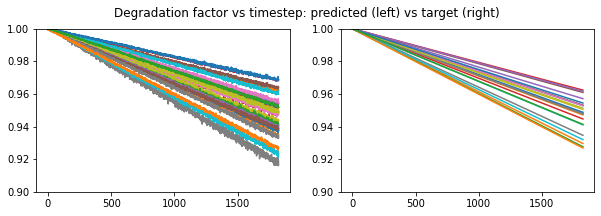

Displaying soil_weather_uniform dataset


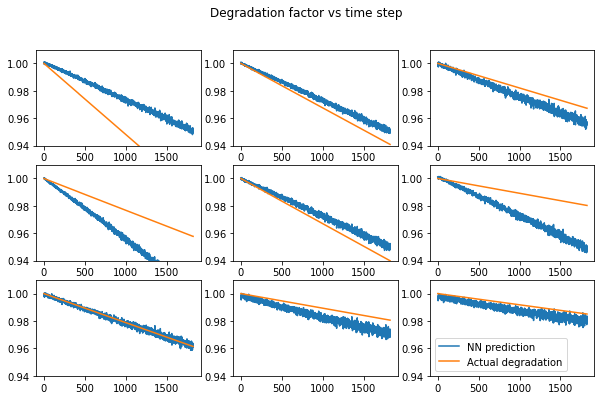

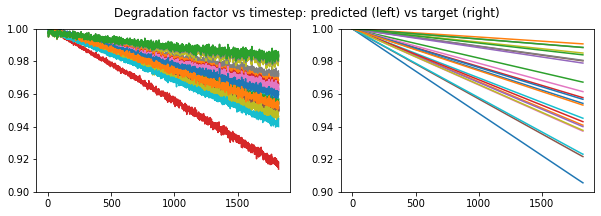

In [7]:
# Visualizing the predictions.
for dataset in datasets: 
    print(f"Displaying {dataset[1]} dataset")
    
    prediction = predictions[dataset[1]]
    y_test = y_tests[dataset[1]]
    
    plt.figure(figsize=(10,6))
    plt.tight_layout()
    plt.suptitle("Degradation factor vs time step")
    for i in range(0, min(len(prediction), 9)):
        plt.subplot(3,3,i+1)
        plt.ylim(0.94,1.01)
        plt.plot([x for x in prediction[i]])
        plt.plot([x for x in y_test[i]])
    plt.legend(['NN prediction','Actual degradation'])
    plt.show()

    plt.figure(figsize=(10,3))
    plt.suptitle("Degradation factor vs timestep: predicted (left) vs target (right)")
    plt.subplot(1,2,1)
    plt.ylim(0.90,1)
    for i in range(0,len(prediction)):
        plt.plot(prediction[i])
    plt.subplot(1,2,2)
    plt.ylim(0.90,1)
    for i in range(0,len(y_test)):
        plt.plot(y_test[i])
    plt.show()

Displaying basic dataset
RMSE is 0.00015554073422220153


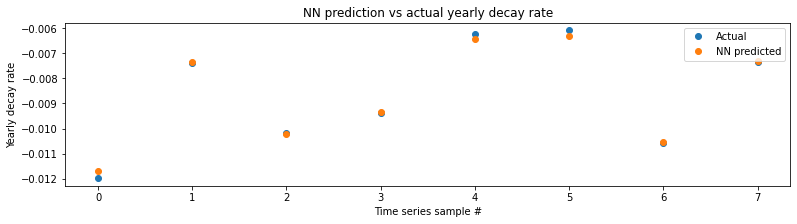

Displaying soil dataset
RMSE is 0.002186667904940907


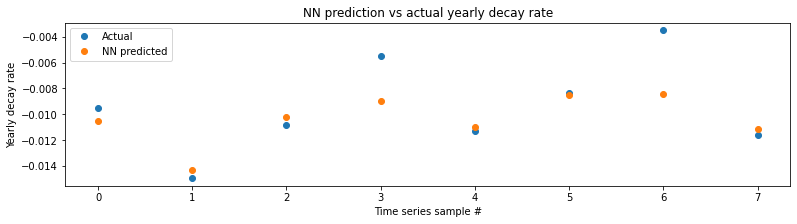

Displaying weather dataset
RMSE is 0.0026374409212504557


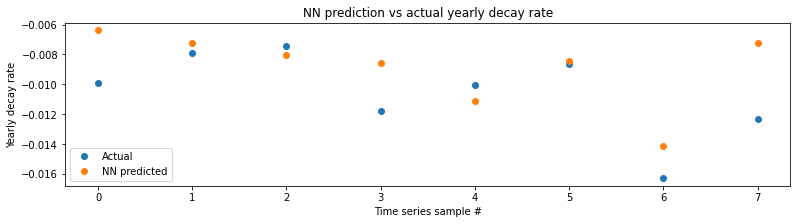

Displaying soil_weather dataset
RMSE is 0.0024482347011220715


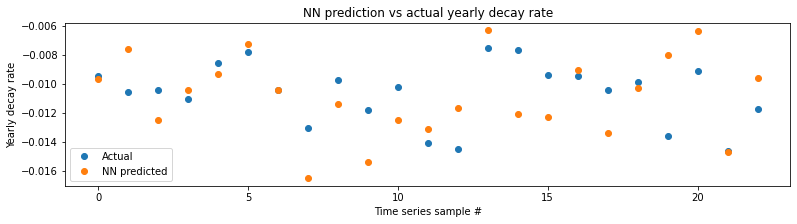

Displaying soil_weather_uniform dataset
RMSE is 0.0040714654192119705


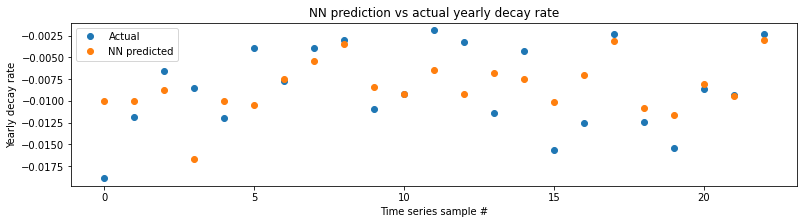

In [8]:
for dataset in datasets:
    # Plotting decay rate (predicted vs target)
    
    print(f"Displaying {dataset[1]} dataset")
    prediction = predictions[dataset[1]]
    y_test = y_tests[dataset[1]]
    
    model_pred = []
    degradation_rates_test = []
    for i in range(0, len(prediction)):
        model_pred.append(extract_yr_degrad(prediction[i, :]))
        degradation_rates_test.append(extract_yr_degrad(y_test[i]))
    mse = mean_squared_error(model_pred, degradation_rates_test)
    print(f"RMSE is {np.sqrt(mse)}")
    
    plt.figure(figsize=(13,3))
    plt.plot(degradation_rates_test, 'o')
    plt.plot(model_pred, 'o')
    plt.xlabel("Time series sample #")
    plt.ylabel("Yearly decay rate")
    plt.title("NN prediction vs actual yearly decay rate")
    plt.legend(["Actual","NN predicted"])
    plt.show()